In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colors as mcolors
#import matplotlib.cm as cm
#import scipy.stats as stats
#from scipy.stats import f_oneway
#from scipy.stats import ttest_ind
#from scipy.stats import describe
#from scipy.stats import mannwhitneyu
#from sklearn.linear_model import LinearRegression
#import sklearn.metrics
import seaborn as sns

TODO:

Tool input: 
- either give a path to the folder which contains the files --amp-results (like funcscan - put in README how the folder should be structured

- OR we give the user the possibility to indicate specific file paths, like: --ampir-outfile, --amplify-outfile etc. (would be in case of few samples - AMPcombi has to be run manually for each sample)

- How to handle different samples? --amp-results points to output of 1 sample? Output is one table per sample in one output directory
- user has an output dir like run/sample1/amp/alloutputs.tsv, run/sample2/amp/alloutputs.tsv -> subdirectories names will be prefix for samples

- OR work with sample sheets?

check which tools were run, read in and merge accordingly

Which marker to use to identify a contig was not attributed to AMPs in one of the tools (python gives NAN at merge, I put -1), how do we want it in the output?

Filtering not in funcscan but in AMPcombi! Put a probability-threshold on tools (except hmmer, which would be evalue) BEFORE merging AFTER formatting

eliminate the the non-AMPs if tools setting (i.e. AMPLIFY) gives them out as well. If more than one tool was run, condition would be that it was non-AMP in all of them. 

For alignment: build new fasta from merged table contig_ids? (see code in https://github.com/louperelo/longmetarg/blob/main/bin/read_analysis.py ) -> fasta with sequences of AMP hits as input to Diamond or MMseq

Database: download to database folder

Output: name output files according to samples (use sample names from directory), use --outdir to name the output folder

In [39]:
#paths to AMP output files
home = '..'
ampir_p = home+'/amp_results/ampir/sample_1/sample_1.ampir.tsv'
amplify_p = home+'/amp_results/amplify/sample_1/sample_1_amplify.tsv'
hmmer_p = home+'/amp_results/hmmer_hmmsearch/sample_1.hmmsearch.txt'# or sample_1_mybacteriocin.tbl
macrel_p = home+'/amp_results/macrel/sample_1/sample_1.macrel.tsv'

In [40]:
# dictionaries to define 
ampir_dict = {'seq_name':'contig_id', 'seq_aa':'seq_aa', 'prob_AMP':'prob_ampir'}
amplify_dict = {'Sequence_ID':'contig_id', 'Sequence':'seq_aa', 'Length':'length', 'Charge':'charge', 'Probability_score':'prob_amplify', 'AMPlify_log_scaled_score':'log_score', 'Prediction':'prediction'}
hmmer_dict = {'level_0':'evalue_hmmer', 'level_1':'score_hmmer', 'level_2':'bias', 'level_3':'eval_domain', 'level_4':'score_domain', 'level_5':'bias_domain', 'level_6':'exp_dom', '-------':'N_dom', '------':'contig_id'}
macrel_dict = {'Access':'contig_id', 'Sequence':'seq_aa', 'AMP_family':'amp_family', 'AMP_probability':'prob_macrel', 'Hemolytic':'hemolytic', 'Hemolytic_probability':'prob_hemo'}


In [41]:
# AMPIR
ampir_df = pd.read_csv(ampir_p, sep='\t').rename(columns=ampir_dict) 
# cut contig_id to remove extra information added by tool
ampir_df['contig_id']=ampir_df['contig_id'].apply(lambda x: x.split()[0])

In [42]:
# AMPLIFY
amplify_df = pd.read_csv(amplify_p, sep='\t').rename(columns=amplify_dict).dropna()
amplify_df = amplify_df[['contig_id', 'seq_aa', 'prob_amplify']]

In [43]:
# MACREL
#set header to second row to skip first line starting with #
macrel_df = pd.read_csv(macrel_p, sep='\t', header=[1]).rename(columns=macrel_dict)
macrel_df = macrel_df[['contig_id', 'seq_aa', 'prob_macrel']]

In [44]:
# HMMER
hmmer_df = pd.read_table(hmmer_p, delim_whitespace=True, header=[15]).reset_index().rename(columns=hmmer_dict)
hmmer_df = hmmer_df.drop(hmmer_df.iloc[:,9:17], axis=1).dropna()
#hmmer_df = hmmer_df[['contig_id', 'evalue_hmmer']]

In [46]:
merge = pd.merge(ampir_df, amplify_df, how='outer', left_on=['contig_id','seq_aa'], right_on = ['contig_id','seq_aa'])
merge = pd.merge(merge, macrel_df, how='outer', left_on=['contig_id','seq_aa'], right_on = ['contig_id','seq_aa'])

merge = pd.merge(merge, hmmer_df, how='outer', on='contig_id')
merge = merge.fillna(-1)
#df = df[(df.col1 > 8) & (df.col2 != 'A')]
# identify non-AMPs: not detected with AMPIR and MACREL, set minimum probability for AMPLIFY
# can min_prob be set for AMPIR and MACREL?
nonamp_df = merge[(merge['prob_ampir']==-1) & (merge['prob_macrel']==-1) & (merge['prob_amplify']<0.5)]
# generate list of non-AMP contig_ids
nonamp_lst = merge[(merge['prob_ampir']==-1) & (merge['prob_macrel']==-1) & (merge['prob_amplify']<0)]['contig_id'].to_list()
# AMP df
df = merge[~merge['contig_id'].isin(nonamp_lst)]

(array([257.,  15.,   6.,  10.,  25.,  45.,  44.,  93., 129., 309.]),
 array([8.00000000e-08, 9.99834420e-02, 1.99966804e-01, 2.99950166e-01,
        3.99933528e-01, 4.99916890e-01, 5.99900252e-01, 6.99883614e-01,
        7.99866976e-01, 8.99850338e-01, 9.99833700e-01]),
 <BarContainer object of 10 artists>)

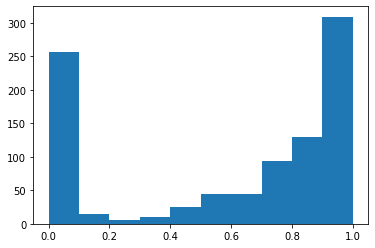

In [49]:
plt.hist(amplify_df['prob_amplify'])

In [48]:
print(merge.shape)
print(non_amps.shape)
print(len(nonamp_lst))

(1016, 13)


NameError: name 'non_amps' is not defined

In [ ]:
df.sort_values('prob_ampir', ascending=False).head(20)

In [ ]:
df[df['evalue_hmmer']!=-1]